In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from sklearn import linear_model
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from scipy.stats.mstats import winsorize
import warnings
warnings.filterwarnings('ignore')

### Sıcaklık Tahmini

In [2]:
df = pd.read_csv('weatherHistory.csv')
df.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


### Model

In [3]:
df = df[['Humidity','Wind Speed (km/h)', 'Pressure (millibars)','Temperature (C)']]
X = df[['Humidity','Wind Speed (km/h)', 'Pressure (millibars)']]
Y = df[['Temperature (C)']]

lrm_ornek = linear_model.LinearRegression()
lrm_ornek.fit(X,Y)
tahmin = lrm_ornek.predict(X)

print('Değişkenler: \n', lrm_ornek.coef_)
print('Sabit değer (bias): \n', lrm_ornek.intercept_)


Değişkenler: 
 [[-3.24398999e+01 -1.94546893e-01 -7.15579969e-04]]
Sabit değer (bias): 
 [38.59379935]


In [4]:
# X = sm.add_constant(X)
# results = sm.OLS(Y,X).fit()
# results.summary()

### Ortalama Hata Varsayımı

Ortalama hatanın sıfır olması gerekliliği varsayımını test edip doğrulayalım:

In [5]:
hatalar = Y - tahmin

print("Tıbbi maliyetler modelinin ortalama hatası : {}".format(np.mean(hatalar)))

Tıbbi maliyetler modelinin ortalama hatası : Temperature (C)    9.240820e-16
dtype: float64


### Homoscedasticity

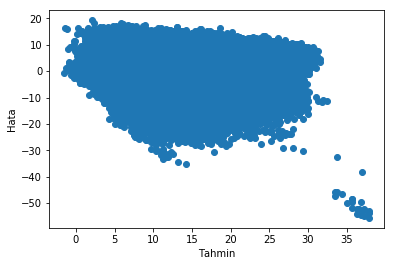

In [6]:
plt.scatter(tahmin, hatalar)
plt.xlabel('Tahmin')
plt.ylabel('Hata')
plt.show()

Hedef değişkenimi çok yükseldiğinde hataların varyansının oldukça büyüdüğünü görüyoruz. Bu bize 'Homoscedasticity' varsayımını sağlayamadığımızı gösteriyor.

Bartlett ve Levene testleriyle bunu daha resmi bir şekilde kontrol edelim:

In [7]:
from scipy.stats import bartlett
from scipy.stats import levene

bart_stats = bartlett(tahmin, hatalar)
lev_stats = levene(tahmin, hatalar)

print(lev_stats, '\n')
print(bart_stats)

LeveneResult(statistic=array([2435.45049023]), pvalue=array([0.])) 

BartlettResult(statistic=2595.3385952614226, pvalue=0.0)


İki testimizde de P değerler 0.05'ten düşüktür. Bu da hataların dağılımının 'Heteroscedastic' olduğu anlamına gelir.

### Çoklu Doğrusallığın İncelenmesi

In [8]:
corr_mat = df.corr()
corr_mat

,Humidity,Wind Speed (km/h),Pressure (millibars),Temperature (C)
Humidity,1.000000,-0.224951,0.005454,-0.632255
Wind Speed (km/h),-0.224951,1.000000,-0.049263,0.008957
Pressure (millibars),0.005454,-0.049263,1.000000,-0.005447
Temperature (C),-0.632255,0.008957,-0.005447,1.000000


### Hataların Birbiriyle İlişkileri

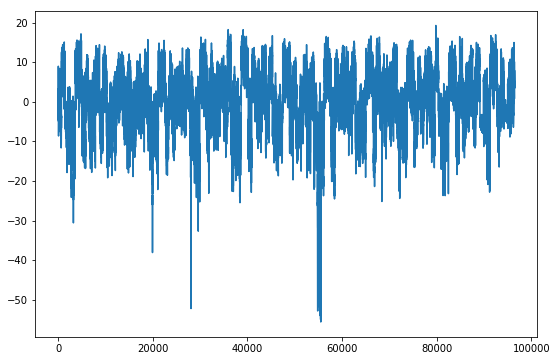

In [9]:
plt.figure(figsize=(9,6))
plt.plot(hatalar)
plt.show()

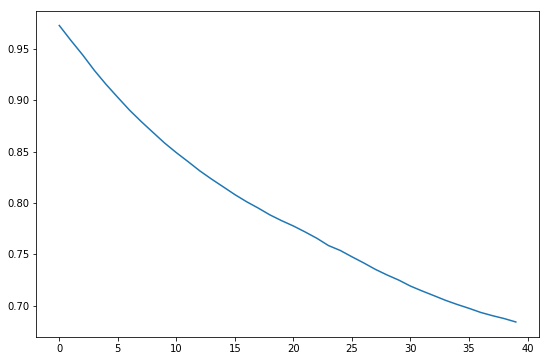

In [10]:
from statsmodels.tsa.stattools import acf

acf_data = acf(hatalar)

plt.figure(figsize=(9,6))
plt.plot(acf_data[1:])
plt.show()

Hatalar arası korelasyonun yüksek olduğunu görüyoruz. Bunun farklı sebepleri olabilir. Seçtiğimiz özellikler uygun olmayabilir. Diğer bir sebebi de verideki özelliklerimizin modeli açıklamakta yetersiz kalması düşünülebilir. Bu durumda yeinden bir özellik mühendisliğinie ihtiyaç duyulabilir. Bunun yanında sonraki süreçte uygulamayı düşündüğüm Generalized Least Squares yöntemi de kullanılabilir.

### Hatalar özelliklerden bağımsız olmalıdır.

In [11]:
df['Hata'] = hatalar
df.corr()

,Humidity,Wind Speed (km/h),Pressure (millibars),Temperature (C),Hata
Humidity,1.000000e+00,-2.249515e-01,5.454263e-03,-0.632255,-9.436067e-15
Wind Speed (km/h),-2.249515e-01,1.000000e+00,-4.926281e-02,0.008957,2.295259e-15
Pressure (millibars),5.454263e-03,-4.926281e-02,1.000000e+00,-0.005447,-2.735854e-16
Temperature (C),-6.322547e-01,8.956968e-03,-5.447106e-03,1.000000,7.625418e-01
Hata,-9.436067e-15,2.295259e-15,-2.735854e-16,0.762542,1.000000e+00


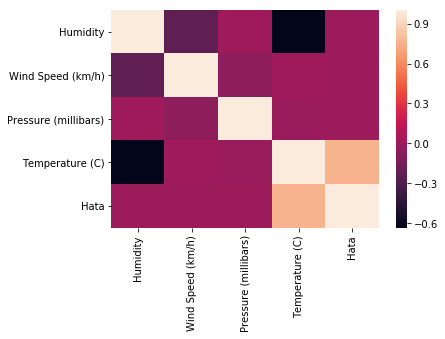

In [12]:
sns.heatmap(df.corr())
plt.show()

Hata değişkenimiz özellik değişkenlerimizle son derece düşük korelasyona sahiptir. 

### Hataların dağılımı

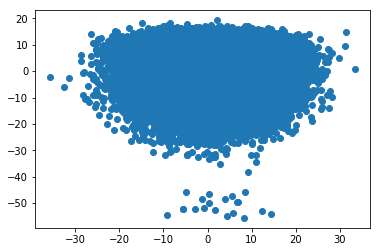

In [13]:
rands = np.random.normal(hatalar.mean(), hatalar.std(), len(hatalar))
plt.scatter(rands, hatalar)
plt.show()

In [14]:
from scipy.stats import jarque_bera
from scipy.stats import normaltest

jb_stats = jarque_bera(hatalar)
norm_stats = normaltest(hatalar)

print('JB Test Results:',jb_stats, '\n')
print(norm_stats)

JB Test Results: (3852.0430009380825, 0.0) 

NormaltestResult(statistic=array([3420.50778308]), pvalue=array([0.]))


P değerlerinin düşük olduğunu gördük. Normal dağılım göstermediğini de Q-Q Plot ile gösterdik. 

### Ev Fiyatları

In [15]:
daf = pd.read_csv('train.csv')
daf.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [16]:
daf = daf.drop(['MiscFeature', 'Alley', 'PoolQC', 'Fence','LotFrontage', 'FireplaceQu' ], axis = 1)
daf = daf.dropna()
ndf = daf[['Street', 'Utilities', 'YearBuilt', 'SalePrice']]

In [17]:
ndf.YearBuilt = ndf.YearBuilt/1880
x_array = np.array(ndf.SalePrice)
x_norm = preprocessing.normalize([x_array])
x = x_norm.T
ndf.SalePrice = x

In [18]:
ndf.SalePrice = winsorize(ndf.SalePrice, 0.045)
ndf.YearBuilt = winsorize(ndf.YearBuilt, 0.007)

In [19]:
ndf["Street"] = ndf.Street.replace({'Pave':1, "Grvl":0})
ndf.Utilities = ndf.Utilities.replace({'AllPub':1, 'NoSeWa':0})

Yukarıdaki işlemlerde özetle; bazı özellikler seçilerek aykırı değerlerden kurtulduk, kategorik değişkenlere dummies  atamalarını gerçekleştirdik ve ölçeklendirmelerizimiz yaptık. Tahminde kullanacağımız veri kümesinin son hali aşağıdaki gibidir.

In [20]:
ndf.head()

,Street,Utilities,YearBuilt,SalePrice
0,1,1,1.065426,0.028115
1,1,1,1.051064,0.024474
2,1,1,1.064362,0.030138
3,1,1,1.018617,0.018878
4,1,1,1.063830,0.033711


### Model

In [21]:
X2 = ndf[['Street', 'Utilities', 'YearBuilt']]
Y2 = ndf[['SalePrice']]

lrm = linear_model.LinearRegression()
lrm.fit(X2,Y2)
tahmin2 = lrm.predict(X2)

### Ortalama Hata Sıfır mı?

In [22]:
hatalar2 = Y2 - tahmin2
hatalar2.mean()

SalePrice   -1.485276e-17
dtype: float64

Ortalama hatanını sıfır olduğunu gördük.

### Homoscedasticity

Text(0, 0.5, 'Hatalar')

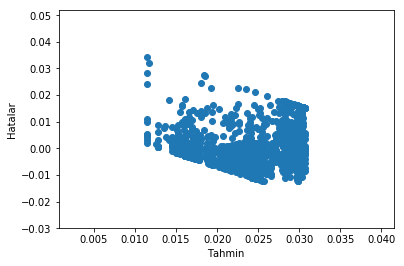

In [28]:
plt.scatter(tahmin2, hatalar2)
plt.xlabel('Tahmin')
plt.ylabel('Hatalar')

In [29]:
bart_stats2 = bartlett(tahmin2, hatalar2)
lev_stats2 = levene(tahmin2, hatalar2)

print(lev_stats2, '\n')
print(bart_stats2)

LeveneResult(statistic=array([77.84140611]), pvalue=array([1.97436274e-18])) 

BartlettResult(statistic=222.43765889430102, pvalue=2.6587715969366072e-50)


Burada P değerlerine baktığımızda modelin heteroscedastic olduğunu görüyoruz.

### Çoklu Doğrusallık


In [30]:
ndf.corr()

,Street,Utilities,YearBuilt,SalePrice
Street,1.000000,-0.001675,0.036443,0.037002
Utilities,-0.001675,1.000000,0.014040,0.019507
YearBuilt,0.036443,0.014040,1.000000,0.551174
SalePrice,0.037002,0.019507,0.551174,1.000000


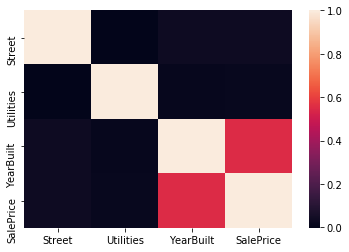

In [31]:
sns.heatmap(ndf.corr())
plt.show()

Özelliklerin birbiriyle doğrusallığı oldukça zayıf. 

### Hatalar özelliklerden bağımsız mı?

In [32]:
ndf['hatalar'] = hatalar
ndf.corr()

,Street,Utilities,YearBuilt,SalePrice,hatalar
Street,1.000000,-0.001675,0.036443,0.037002,-0.023856
Utilities,-0.001675,1.000000,0.014040,0.019507,-0.048367
YearBuilt,0.036443,0.014040,1.000000,0.551174,-0.012606
SalePrice,0.037002,0.019507,0.551174,1.000000,-0.017247
hatalar,-0.023856,-0.048367,-0.012606,-0.017247,1.000000


Hataların diğer özellik değişkenleriyle korelasyonu düşük. Bu varsayımı karşılıyoruz.

### Hataların dağılımı normal mi?

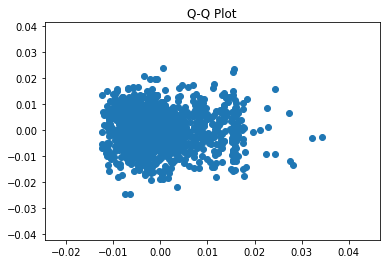

In [44]:
randoms = np.random.normal(hatalar2.mean(), hatalar2.std(), len(hatalar2))
plt.scatter(hatalar2, randoms)
plt.title('Q-Q Plot')
plt.show()

In [37]:
from scipy.stats import jarque_bera
from scipy.stats import normaltest

jarq_stats = jarque_bera(hatalar2)
nor_stats = normaltest(hatalar2)

print('Jarque Bera Stats:', jarq_stats, '\n')
print(nor_stats)

Jarque Bera Stats: (310.22595195164575, 0.0) 

NormaltestResult(statistic=array([205.01385357]), pvalue=array([3.0325456e-45]))


Q_Q Plot ve istatistiklerde gördüğümüz üzere hatalar normal dağılım göstermemektedir.